# Excess PKIN  Events

The CityIQ API for the San Diego system appears to be reporting excessive PKIN events, which, over about a month of records, results in a calculated excess of 80,000 cars in the San Diego system. For the dowtown neighborhood, the excess is about 1.8%; the PKIN and PKOUT records can be ballanced by reducing the number of PKIN records by 1.8%



In [1]:
import datetime
import statsmodels.formula.api as sm
from cityiq import Config, CityIq
from cityiq.scrape import EventScraper
tz = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo

In [57]:
f = '/Users/eric/proj/virt-proj/data-project/sdrdl-data-projects/sandiego.gov/predix.io/prod-credentials.yaml'
config = Config(f)

c = CityIq(config) # Maybe will need this later

# Scrape events from the API from Jan 1, 2019 to the current date, which is about Feb 9
start_time = datetime.datetime(2019, 1, 1, 0, 0, tzinfo = tz)
s = EventScraper(config, start_time,  ['PKIN', 'PKOUT'])

# We only need a few of the record values. 
from operator import itemgetter
keys = ['timestamp','locationUid', 'eventType']
ig = itemgetter(*keys)

parking_geo = pd.read_csv('parking_geo.csv')

df = pd.DataFrame( [ ig(e) for e in s.iterate_records()], 
                  columns=keys).sort_values('timestamp')

dfcm = dfcm.merge(parking_geo[['locationUid', 'geoid','community_name']], how='left', on='locationUid')



In [5]:
df['ts_rounded'] = (df.timestamp/1000).round(0).astype(int) # Quantize to 1 s
df['time'] =  pd.to_datetime(df.ts_rounded, unit = 's')

df['delta'] = df.eventType.apply(lambda v: 1 if v == 'PKIN' else -1)
df = df.sort_values('time')


,timestamp,locationUid,eventType,ts_rounded,time,delta
511,1546329601203,ldk9g5eo1ejl6lntv4,PKIN,1546329601,2019-01-01 08:00:01,1
1042,1546329601316,4uyu9btqazijiysoww3,PKOUT,1546329601,2019-01-01 08:00:01,-1
194,1546329601341,8n2r4w1w0zjishkrxo,PKIN,1546329601,2019-01-01 08:00:01,1
78,1546329603385,2q4lqblj667jlfi8z71,PKIN,1546329603,2019-01-01 08:00:03,1
958,1546329603409,28w904jom5hjjhgn737,PKOUT,1546329603,2019-01-01 08:00:03,-1


In [49]:
print("""Number of Records: {:,}
Start Time       : {}
End Time         : {}""".format(len(df), df.time.min(), df.time.max()))

Number of Records: 8,418,375
Start Time       : 2019-01-01 08:00:01
End Time         : 2019-02-08 09:57:42


The source data has a lot of duplicate records, records of one event type, for one locationUid, which occur in batches within one second or so. These can be seen most notably as the large jumps on 16 Jan and 25 Jan, but there are many others, about 30,000 duplicate records in this period.  The plot below shows the cumlative number of cars in parking zones, where each PKIN increments the count and each PKOUT decrements the counts. We'd expect that the slope of this plot would be zero, but it is significantly incresing, indicating that there is an excess of PKIN records. 

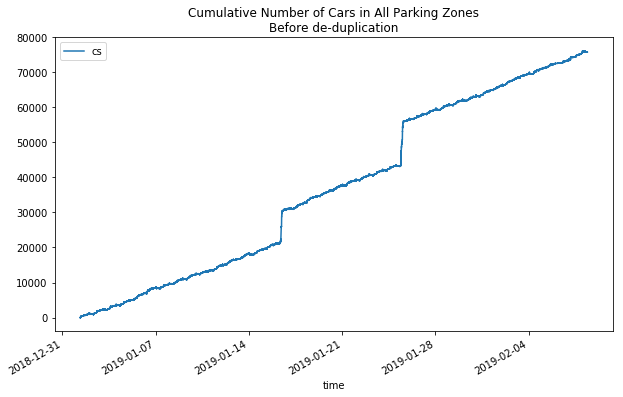

In [43]:
dfcm = df.copy()
dfcm['cs'] = dfcm.delta.cumsum()
ax = dfcm.plot(x='time',y='cs', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nBefore de-duplication');

In [54]:
t = dfcm.delta.value_counts()
((t.iloc[0] - t.iloc[1])/t.iloc[0] * 100).round(2)

1.79

Removing these records eliminates the two large jumps and removes about 30,000 records, but the positive slope remains, because there are about 1.8% more PKIN events than PKOUT events. 

Text(0.5,1,'Cumulative Number of Cars in All Parking Zones\nAfter de-duplication')

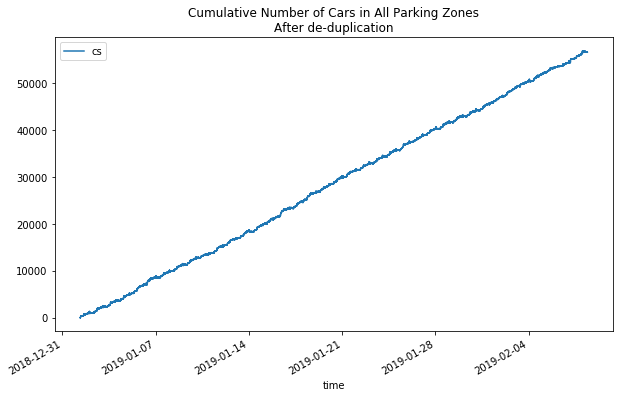

In [8]:
dfcm = df.copy().sort_values('timestamp')
dfcm['ts'] = dfcm.ts_rounded - dfcm.ts_rounded.iloc[0] # Seconds from start of dataset
dfcm = dfcm.sort_values(['time', 'eventType']).drop_duplicates(subset=['time', 'eventType', 'locationUid'])
dfcm['cs'] = dfcm.delta.cumsum()

ax = dfcm.plot(x='time',y='cs', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter de-duplication')


One method to correct these errors is to compute the slope of the trend, then subtract it out. 

In [55]:

dfcm['ts'] = dfcm.ts_rounded - dfcm.ts_rounded.iloc[0] # Seconds from start of dataset
dfcm['C'] = 1
result = sm.ols(formula=" cs ~ ts + C", data=dfcm).fit()
print(result.params)



Intercept   -2718.866006
ts              0.025809
C           -2718.866006
dtype: float64


75823 23796.037250000292


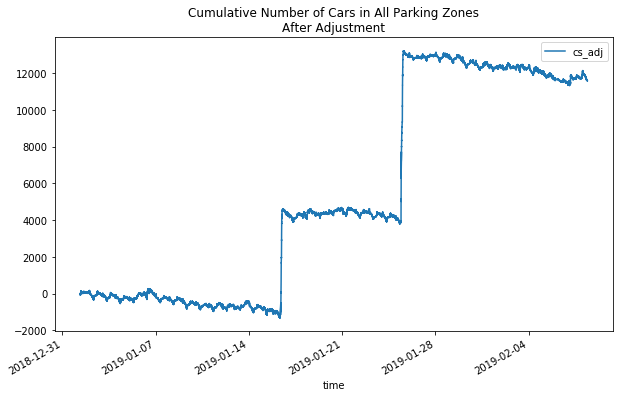

In [59]:

dfcm['C'] = 1
dfcm['rand'] = np.random.rand(dfcm.shape[0])
# The factor here, 0.013480 is based on the regression coeff above, then adjusted to make
# the oscilating parts of the plot mostly flat. 
dfcm['delta_adj'] = dfcm.delta.where( (dfcm.delta<0), 1-0.01225)

dfcm['cs_adj'] = dfcm.delta_adj.cumsum()
print(dfcm.delta.sum(), dfcm.delta_adj.sum())

#ax =dfcm.plot(x ='ts', y='cs_adj', figsize = (10,6))
#ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter Adjustment');

t = dfcm[dfcm.community_name == 'Downtown'].copy()
t['cs_adj'] = t.delta_adj.cumsum()
ax = t.plot(x ='time', y='cs_adj', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter Adjustment');



In [11]:
dfcm[dfcm.community_name == 'Downtown'].delta.value_counts()

 1    2732495
-1    2699424
Name: delta, dtype: int64

In [12]:
2732495 / 2699424

1.0122511320933651

In [13]:
t.cs_adj.min(),  t.cs_adj.max(), t.cs_adj.max()-t.cs_adj.min()

(-625.3132499886908, 871.0415000078856, 1496.3547499965764)

Parking events per neighborhood

In [14]:
dfcm.groupby('community_name').timestamp.count().sort_values(ascending=False).head(10)

community_name
Downtown                        5431919
Balboa Park                      665547
Uptown                           537783
Greater North Park               498727
Mid-City:Eastern Area            169037
College Area                     129265
Ocean Beach                      127531
Mid-City:Normal Heights           79928
Mid-City:Kensington-Talmadge      70442
Greater Golden Hill               61440
Name: timestamp, dtype: int64

Parking zones per neighborhood

In [15]:
dfcm.groupby('community_name').locationUid.nunique().sort_values(ascending=False).head(10)

community_name
Downtown                  544
Uptown                     96
Balboa Park                94
Greater North Park         79
Mid-City:Eastern Area      42
Skyline-Paradise Hills     31
Greater Golden Hill        19
College Area               18
Mira Mesa                  15
Ocean Beach                13
Name: locationUid, dtype: int64

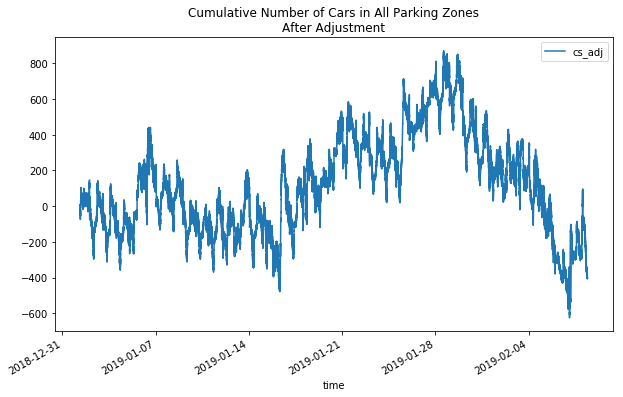

In [16]:
t = dfcm[dfcm.community_name == 'Downtown'].copy()
t['cs_adj'] = t.delta_adj.cumsum()
ax = t.plot(x ='time', y='cs_adj', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter Adjustment');


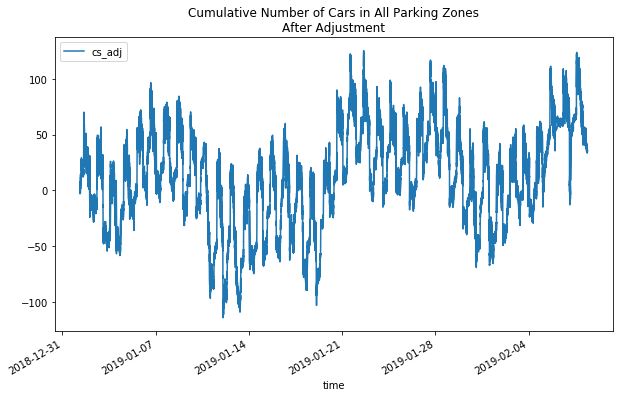

In [17]:
t = dfcm[dfcm.community_name == 'Uptown'].copy()
t['cs_adj'] = t.delta_adj.cumsum()
ax = t.plot(x ='time', y='cs_adj', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter Adjustment');


In [18]:
dfcm[dfcm.community_name == 'Pacific Beach'].locationUid.nunique()

12

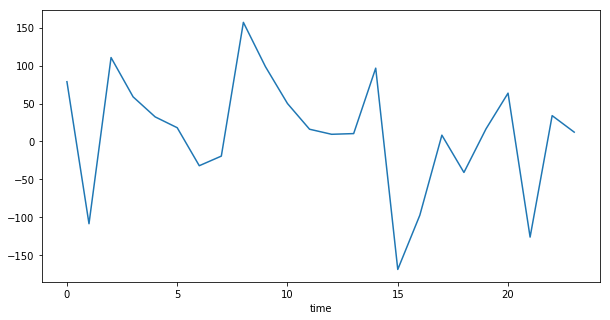

In [19]:
t = dfcm[dfcm.community_name == 'Ocean Beach']
t =t.groupby(t.time.dt.hour).delta_adj.sum()
t.plot(figsize=(10,5))

In [20]:
dfcm[dfcm.community_name == 'Uptown'].groupby('locationUid').count().eventType.sort_values(ascending=False).head()

locationUid
tnu9csk2m3jiq0k60w     29956
wj89u8nssegjiq9vdzg    25503
q3rkq130uhjiom604t     23687
9bd4js9tmxejikknki6    22484
pf7c2xd2ymqjlns0s2h    20109
Name: eventType, dtype: int64

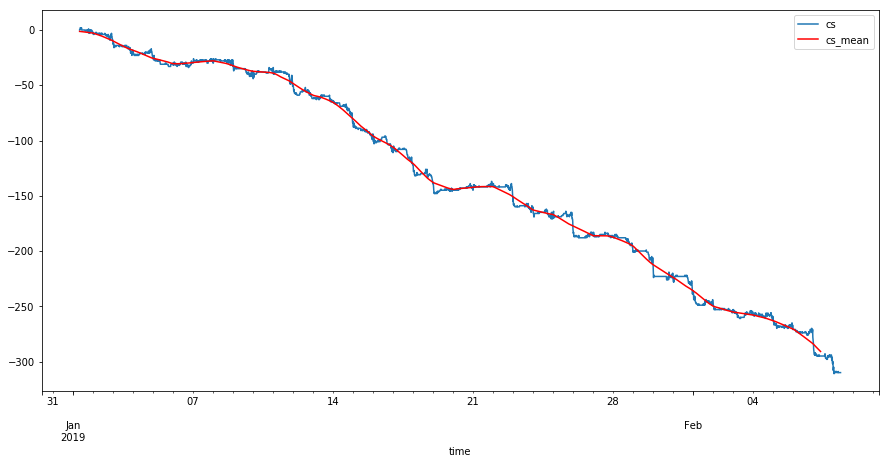

In [21]:
t = df[df.locationUid == 'tnu9csk2m3jiq0k60w']
t = t.sort_values(['time', 'eventType']).drop_duplicates(subset=['time', 'eventType'])
t = t.sort_values('time').set_index('time').resample('15Min').sum()
t['cs'] = t.delta.cumsum()
t['cs_mean'] = t.cs.rolling('2d', closed='left').mean().shift(-24*4)


ax = t.plot(y='cs', figsize=(15, 7))
t.plot(ax=ax, y='cs_mean', color='red')

Note that there are a lot of large jumps, which happen most often around midnight

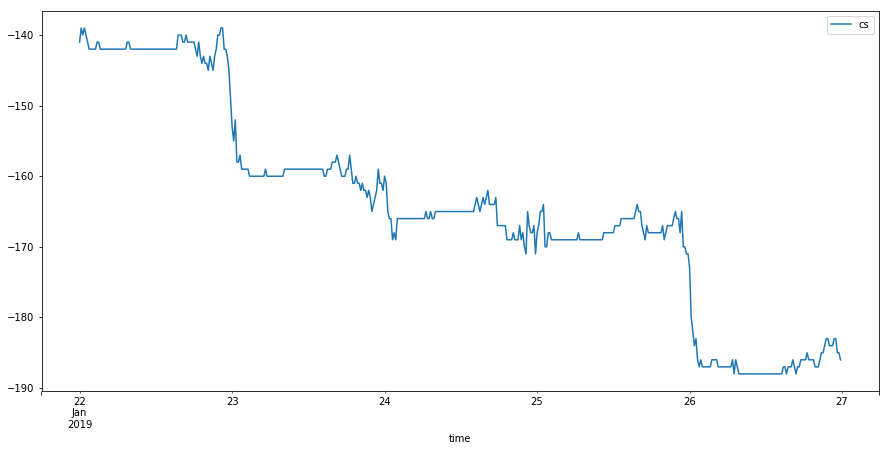

In [22]:
t.loc['2019-01-22':'2019-01-26'].plot(y='cs', figsize=(15, 7))

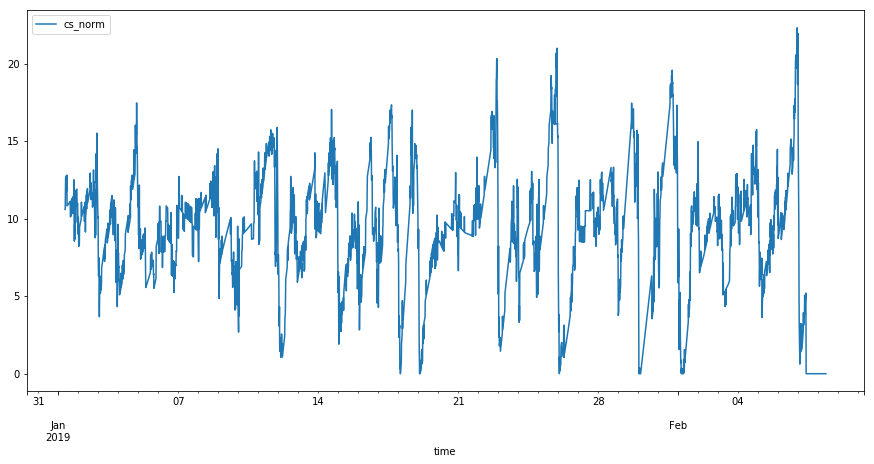

In [23]:
t['cs_norm'] = (t.cs - t.cs_mean) 
cs_min = t.groupby(pd.Grouper(freq='3D')).cs_norm.min().describe().loc['25%']
t['cs_norm'] = t.cs_norm - cs_min
t['cs_norm'] = t.cs_norm.where(t.cs_norm>0, 0 )
t.plot(y='cs_norm', figsize=(15, 7))

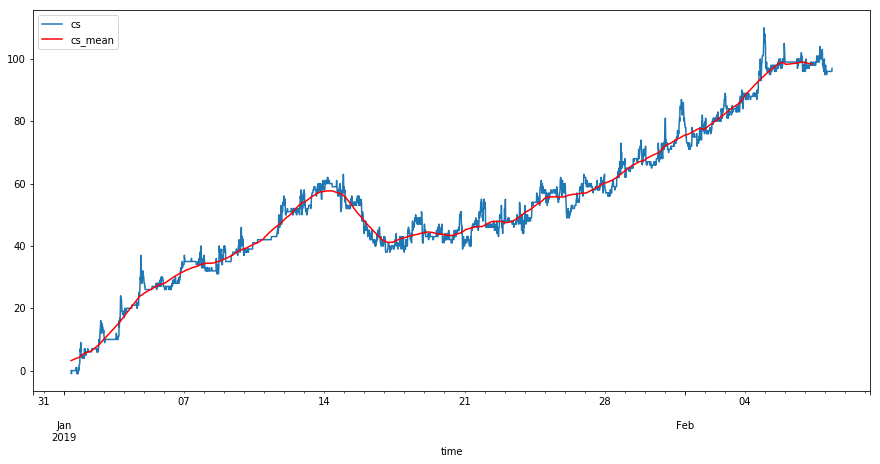

In [24]:
t = df[df.locationUid == 'wj89u8nssegjiq9vdzg']
t = t.sort_values(['time', 'eventType']).drop_duplicates(subset=['time', 'eventType'])
t = t.sort_values('time').set_index('time').resample('15Min').sum()
t['cs'] = t.delta.cumsum()
t['cs_mean'] = t.cs.rolling('2d', closed='left').mean().shift(-24*4)


ax = t.plot(y='cs', figsize=(15, 7))
t.plot(ax=ax, y='cs_mean', color='red')

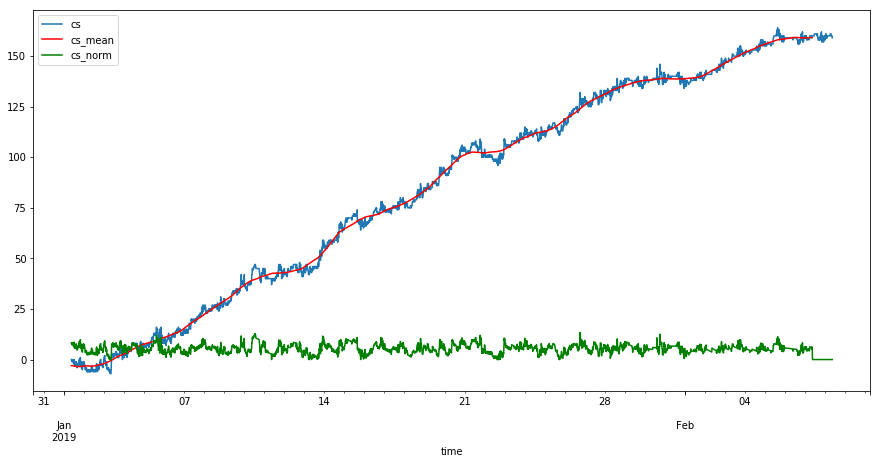

In [25]:


def re_norm_location(df):

    t = df.sort_values(['time', 'eventType'])\
         .drop_duplicates(subset=['time', 'eventType'])\
         .set_index('time')\
         .resample('15Min')\
         .sum()

    t['cs'] = t.delta.cumsum()
    
    # Find a two day rolling average
    t['cs_mean'] = t.cs.rolling('2d', closed='left').mean().shift(-24*4)

    # Substract off the mean. This makes the long term slope zero, like it should be
    t['cs_norm'] = (t.cs - t.cs_mean) 
    # The lowest value should be zero, but since it almost never is, we'll take the 25the percentile of 
    # the daily minimums as the zero point. 
    cs_min = t.groupby(pd.Grouper(freq='2D')).cs_norm.min().describe().loc['25%']

    # Sift the whole curve so the min value is zero. 
    t['cs_norm'] = t.cs_norm - cs_min
    
    # But, since we used the 25th percentile for the min, there are still some values that
    # are negative. Just truncate those. 
    t['cs_norm'] = t.cs_norm.where(t.cs_norm>0, 0 )

    
    # Put the deltas back on. We'll need them to aggregate multiple locatios together, 
    # becuase the cs_* field are only correct for this location. 
    t['cs_int'] = t.cs_norm.round(0).astype(int)
    t['delta'] = t.cs_int.diff().fillna(0).astype(int)
    
    return t

def plot_loc_norming(t):
    ax = t.plot(y='cs', figsize=(15, 7))
    t.plot(ax=ax, y='cs_mean', color='red')
    t.plot(ax=ax, y='cs_norm', color='green')
    
t = re_norm_location(df[df.locationUid == 'q3rkq130uhjiom604t'])
plot_loc_norming(t)

In [26]:
from tqdm import tqdm_notebook as tqdm
g = df.groupby('locationUid')
locations = []
for gname, gframe in tqdm(g):
    #df = g.get_group(gname)
    t =  re_norm_location(gframe)
    t['locationUid'] = gname
    locations.append(t)

HBox(children=(IntProgress(value=0, max=1088), HTML(value='')))

In [27]:
len(locations)

1088

In [28]:
comb = pd.concat(locations)[['locationUid', 'delta']]

In [29]:
len(comb)

3804028

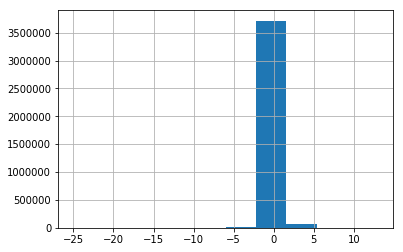

In [30]:
comb.delta.hist()

In [31]:
comb

,locationUid,delta
time,,
2019-01-01 10:30:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 10:45:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 11:00:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 11:15:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 11:30:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 11:45:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 12:00:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 12:15:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 12:30:00,03e23a6ace01fc14a86ab250ce65b682,0


In [37]:
t = comb.copy()
t.sort_index(inplace=True)
t['cs'] =  t.delta.cumsum()

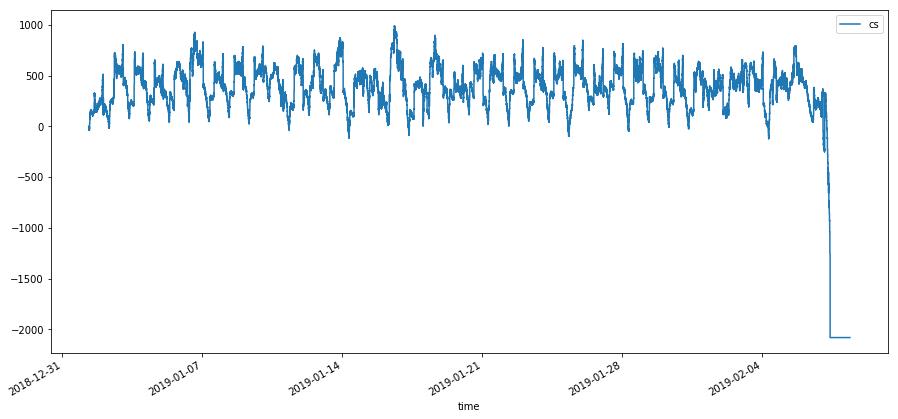

In [38]:
t.plot(y='cs', figsize=(15, 7))

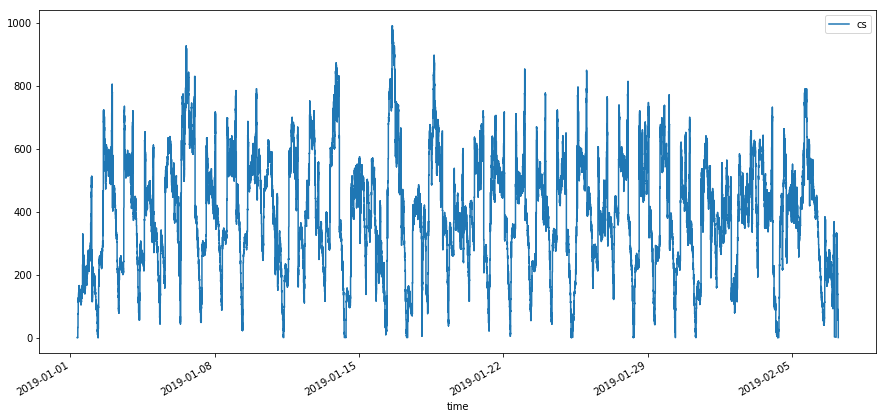

In [40]:
t[t.cs > 0].plot(y='cs', figsize=(15, 7))

In [42]:
t.cs.mean()

341.56270642592534

In [58]:
comb.to_csv('events.csv')